# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Read Datasets 
# research_data = pd.read_csv('Datasets/BlockChain_Train_csv.csv')
# research_data.head()

# Read Datasets 
research_data = pd.read_csv('Datasets/gemini_BTCUSD_1hr_mod.csv')
research_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1559433600000,2019-06-02 00:00:00,BTCUSD,8566.10,8567.20,8546.38,8567.20,0.899330
1,1559430000000,2019-06-01 23:00:00,BTCUSD,8587.25,8598.10,8527.58,8566.10,156.493022
2,1559426400000,2019-06-01 22:00:00,BTCUSD,8598.89,8604.16,8542.44,8587.25,11.841891
3,1559422800000,2019-06-01 21:00:00,BTCUSD,8543.90,8609.96,8541.67,8598.89,18.957024
4,1559419200000,2019-06-01 20:00:00,BTCUSD,8538.75,8569.69,8532.23,8543.90,18.051794


In [4]:
research_data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
31975,1444323600,2015-10-08 17:00:00,BTCUSD,244.25,244.99,244.02,244.99,3.920632
31976,1444320000,2015-10-08 16:00:00,BTCUSD,244.92,244.92,244.25,244.25,3.895252
31977,1444316400,2015-10-08 15:00:00,BTCUSD,245.00,245.00,244.92,244.92,3.016926
31978,1444312800,2015-10-08 14:00:00,BTCUSD,245.00,245.00,244.50,245.00,4.453649
31979,1444309200,2015-10-08 13:00:00,BTCUSD,0.00,245.00,0.00,245.00,0.606654


In [5]:
TIME_STEPS = 256
BATCH_SIZE_OUT = 20 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [6]:
# Normalize and convert DataFrame into ndArray
# train_cols = ["Open","High","Low","Close","Volume USD","Popularity_Normalized"]
#train_cols = ["Close","TransactionsPerBlock","USD_Exchange_Trade_Volume","BlockSize_d","Total_Number_of_Transactions_d","Estimated_Transaction_Value_USD"]
train_cols = ["Close"]

df_train, df_test = train_test_split(research_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train_out = min_max_scaler.fit_transform(x)
x_test_out = min_max_scaler.transform(df_test.loc[:,train_cols])


Train and Test size 25584 6396


In [7]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
#     for i in tqdm_notebook(range(dim_0)):
#         x[i] = mat[i:TIME_STEPS+i]
#         y[i] = mat[TIME_STEPS+i, y_col_index]
#     print("length of time-series i/o",x.shape,y.shape)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    #print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [8]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE_OUT
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [9]:
def load_data(x_train, x_test, batch_size):
    x_t, y_t = build_timeseries(x_train, 0) # index of output (3)
    x_t = trim_dataset(x_t, batch_size)
    y_t = trim_dataset(y_t, batch_size)
    x_temp, y_temp = build_timeseries(x_test, 0) # index of output (3)
    x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size),2)
    y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size),2)
    
    return [x_t, y_t, x_val, x_test_t, y_val, y_test_t]

In [10]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [11]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(1))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, 16)                  1152      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (20, 16)                  0         
_________________________________________________________________
dropout_1 (Dropout)          (20, 16)                  0         
_________________________________________________________________
dense_1 (Dense)              (20, 1)                   17        
_________________________________________________________________
activation_1 (Activation)    (20, 1)                   0         
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [12]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(32, TIME_STEPS, 1)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (32, 256, 16)             32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (32, 256, 16)             0         
_________________________________________________________________
dropout_2 (Dropout)          (32, 256, 16)             0         
_________________________________________________________________
dense_3 (Dense)              (32, 256, 8)              136       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (32, 256, 8)              0         
_________________________________________________________________
dropout_3 (Dropout)          (32, 256, 8)              0         
_________________________________________________________________
dense_4 (Dense)              (32, 256, 1)              9         
Total para

In [13]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 1)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 1)            0         
_________________________________________________________________
sequential_1 (Sequential)    multiple                  1169      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  177       
Total params: 1,346
Trainable params: 1,169
Non-trainable params: 177
_________________________________________________________________


In [14]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global y_train
    global X_val
    global X_test
    global y_val
    global y_test
    
    
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    #(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    # generator = create_generator()
    # discriminator = create_discriminator()
    # gan = create_gan(discriminator, generator)
    #gan = create_gan2(discriminator, generator)
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            #noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            
            #dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            dim_1 = generated_prices.shape[1]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 1))

            #print('Shapes 1')
            #print(noise.shape)
            #print(prices_batch.shape)
            #print(generated_prices.shape)     
            #print(gen_prices.shape)
            #print(prices_batch)
            #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, X_train.shape[2]))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
            #print('Shapes 2')
            #print(X.shape)
            #print(y_dis.shape)
            #print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            #noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #print('Shapes 3')
            #print(noise.shape)
            #print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
        if e == 1 or e % 5 == 0:
            # generate synthetic dataset
            gen_samples_set = []
            for batch_idx in range(int(len(X_train) / batch_size)):
            # for batch_idx in range(int(len(X_train) / 100)):
                # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
                #noise= np.random.normal(0,1, [batch_size, 8])
                #noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
                noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
                generated_data = generator.predict(noise)
                gen_samples_set.append(generated_data)

            gen_samples = np.vstack(gen_samples_set)

In [ ]:
#training(400,128)
training(50,12)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 12/12 [00:04<00:00,  5.37it/s]


1: [D loss: 0.706910, acc: 0.366333]  [A loss: 0.694595, acc: 0.450000]


  8%|▊         | 1/12 [00:00<00:01,  6.29it/s]

Epoch 2


  8%|▊         | 1/12 [00:00<00:01,  7.19it/s]

2: [D loss: 0.698098, acc: 0.447632]  [A loss: 0.701248, acc: 0.150000]
Epoch 3


  8%|▊         | 1/12 [00:00<00:01,  6.56it/s]

3: [D loss: 0.699982, acc: 0.468750]  [A loss: 0.704931, acc: 0.050000]
Epoch 4


  8%|▊         | 1/12 [00:00<00:01,  6.66it/s]

4: [D loss: 0.696204, acc: 0.472900]  [A loss: 0.707830, acc: 0.200000]
Epoch 5


100%|██████████| 12/12 [00:01<00:00,  6.54it/s]

5: [D loss: 0.695107, acc: 0.476196]  [A loss: 0.707883, acc: 0.000000]



  8%|▊         | 1/12 [00:00<00:01,  7.13it/s]

Epoch 6


  8%|▊         | 1/12 [00:00<00:01,  7.10it/s]

6: [D loss: 0.693366, acc: 0.478760]  [A loss: 0.712452, acc: 0.000000]
Epoch 7


  8%|▊         | 1/12 [00:00<00:01,  6.96it/s]

7: [D loss: 0.692764, acc: 0.479248]  [A loss: 0.722237, acc: 0.000000]
Epoch 8


  8%|▊         | 1/12 [00:00<00:01,  6.08it/s]

8: [D loss: 0.691230, acc: 0.481323]  [A loss: 0.732936, acc: 0.000000]
Epoch 9


  0%|          | 0/12 [00:00<?, ?it/s]

9: [D loss: 0.688739, acc: 0.483032]  [A loss: 0.729110, acc: 0.000000]
Epoch 10


100%|██████████| 12/12 [00:01<00:00,  7.73it/s]


10: [D loss: 0.687495, acc: 0.481934]  [A loss: 0.737890, acc: 0.000000]


In [16]:
# generated_data = np.transpose(gen_samples)
# #print(gen_samples)
# #print(generated_data)
# #plot the log-returns
# gen_ind = 1 # change in function price as well
# pd.DataFrame(gen_samples).plot()

In [17]:
def get_2D_array_values(arr, idx):
    arr_map = []
    for i in range(len(arr)):
        arr_map.append(arr[i][idx])
    
    return arr_map

Text(0,0.5,'Loss')

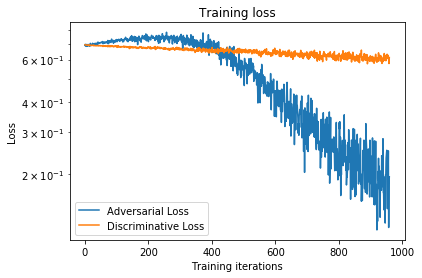

In [18]:
adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss_map,
        'Discriminative Loss': discrimator_loss_map,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

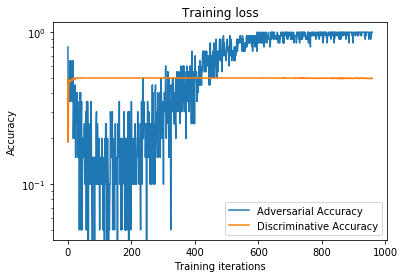

In [19]:
adversarial_acc_map = get_2D_array_values(adversarial_loss, 1)
discrimator_acc_map = get_2D_array_values(discrimator_loss, 1)

ax_acc = pd.DataFrame(
    {
        'Adversarial Accuracy': adversarial_acc_map,
        'Discriminative Accuracy': discrimator_acc_map,
    }
).plot(title='Training loss', logy=True)
ax_acc.set_xlabel("Training iterations")
ax_acc.set_ylabel("Accuracy")

In [20]:
#(X_train2, X_test2, y_train2, y_test2) = load_data_with_test2()
#(X_train2, y_train2, X_val2, X_test2, y_val2, y_test2) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

# print(x_train_out.shape)
# print(x_test_out.shape)

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

prediction_gan = gan.predict(X_test)

# print("The Explained Variance: %.2f" % prediction_gan.score(X_test2, y_test2))  
print("The Explained Variance: %.2f" % metrics.explained_variance_score(y_test, prediction_gan))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_gan))  
#print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test2, prediction_gan)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_gan)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_gan))))

#generator.predict(X_train)[0]

The Explained Variance: 0.00
The Mean Absolute Error: 0.92
The Mean Squared Error: 0.84
The Root Mean Squared Error: 0.92


In [34]:
y_pred = gan.predict(trim_dataset(X_test, BATCH_SIZE_OUT), batch_size=BATCH_SIZE_OUT)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test, BATCH_SIZE_OUT)
error = metrics.mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.9779647815899191 (3180,) (3180,)
[0.9846112  0.98461133 0.9846112  0.98461133 0.98461133 0.98461133
 0.9846112  0.9846112  0.9846112  0.98461133 0.98461133 0.98461133
 0.98461133 0.98461133 0.9846112 ]
[-0.00187447 -0.00195998 -0.00187498 -0.00187498 -0.00187498 -0.00198007
 -0.00206197 -0.00204497 -0.00189765 -0.00192649 -0.00187498 -0.00191877
 -0.00187395 -0.0019677  -0.00193113]


In [35]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_pred_org = (y_pred + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_test_t_org = (y_test_t + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[19571.11  19571.111 19571.11  19571.111 19571.111 19571.111 19571.11
 19571.11  19571.11  19571.111 19571.111 19571.111 19571.111 19571.111
 19571.11 ]
[419.97 418.31 419.96 419.96 419.96 417.92 416.33 416.66 419.52 418.96
 419.96 419.11 419.98 418.16 418.87]


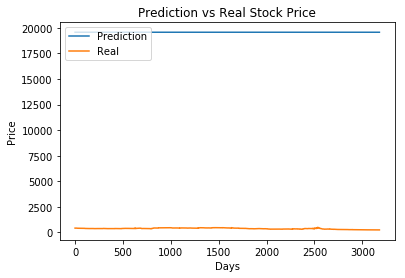

In [36]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
